In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import *
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [4]:
path = Path('data/rossmann/')
train_df = pd.read_pickle(path/'train_clean')

In [5]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [6]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [7]:
n = len(train_df); n

844338

### Experimenting with a sample

In [8]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [9]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
1155,43,4,"Jan,Apr,Jul,Oct",4880.0,73,5982
2266,41,3,"Jan,Apr,Jul,Oct",1180.0,77,5673
2651,427,3,"Jan,Apr,Jul,Oct",70.0,77,8386
2985,761,3,NaN,2390.0,54,9150
3063,839,3,NaN,240.0,54,4616


In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
428189,697,2,"Jan,Apr,Jul,Oct",3780.0,69,7419
428472,981,2,NaN,2620.0,73,5440
428519,1028,2,"Jan,Apr,Jul,Oct",150.0,69,3763
428717,112,1,NaN,1630.0,87,5930
428803,199,1,"Mar,Jun,Sept,Dec",6360.0,74,6768


In [11]:
??Categorify

Init signature: Categorify(cat_names:Collection[str], cont_names:Collection[str]) -> None
Source:        
class Categorify(TabularProc):
    "Transform the categorical variables to that type."
    def apply_train(self, df:DataFrame):
        self.categories = {}
        for n in self.cat_names:
            df.loc[:,n] = df.loc[:,n].astype('category').cat.as_ordered()
            self.categories[n] = df[n].cat.categories

    def apply_test(self, df:DataFrame):
        for n in self.cat_names:
            df.loc[:,n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)
File:           ~/.local/lib/python3.6/site-packages/fastai/tabular/transform.py
Type:           type


In [14]:
doc(Categorify)

class Categorify [source] Categorify ( cat_names : StrList , cont_names : StrList ) :: TabularProc 
 
 Transform the categorical variables to that type. 
 Show in docs

In [15]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [16]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
428189,697.0,2,"Jan,Apr,Jul,Oct",3780.0,69,7419
428472,981.0,2,NaN,2620.0,73,5440
428519,NaN,2,"Jan,Apr,Jul,Oct",150.0,69,3763
428717,NaN,1,NaN,1630.0,87,5930
428803,NaN,1,"Mar,Jun,Sept,Dec",6360.0,74,6768


In [17]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [19]:
small_train_df['PromoInterval'].cat.codes[:10]

1155    1
2266    1
2651    1
2985   -1
3063   -1
3100   -1
3119   -1
3975   -1
4557   -1
4578    1
dtype: int8

In [20]:
doc(FillMissing)

class FillMissing [source] FillMissing ( cat_names : StrList , cont_names : StrList , fill_strategy : FillStrategy = <FillStrategy.MEDIAN: 1> , add_col : bool = True , fill_val : float = 0.0 ) :: TabularProc 
 
 Fill the missing values in continuous columns. 
 Show in docs

In [33]:
small_train_df[small_train_df.CompetitionDistance.isnull()]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
185749,622,2,NaN,NaN,93,4508
216017,291,4,NaN,NaN,80,12327
355512,879,6,"Feb,May,Aug,Nov",NaN,59,3364
427260,879,3,"Feb,May,Aug,Nov",NaN,78,2221


In [34]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [35]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
185749,622,2,NaN,2295.0,93,4508,True
216017,291,4,NaN,2295.0,80,12327,True
355512,879,6,"Feb,May,Aug,Nov",2295.0,59,3364,True
427260,879,3,"Feb,May,Aug,Nov",2295.0,78,2221,True


In [36]:
doc(Normalize)

class Normalize [source] Normalize ( cat_names : StrList , cont_names : StrList ) :: TabularProc 
 
 Normalize the continuous variables. 
 Show in docs

In [37]:
small_train_df.head(5)

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
1155,43,4,"Jan,Apr,Jul,Oct",4880.0,73,5982,False
2266,41,3,"Jan,Apr,Jul,Oct",1180.0,77,5673,False
2651,427,3,"Jan,Apr,Jul,Oct",70.0,77,8386,False
2985,761,3,NaN,2390.0,54,9150,False
3063,839,3,NaN,240.0,54,4616,False


In [38]:
small_cat_vars

['Store', 'DayOfWeek', 'PromoInterval', 'CompetitionDistance_na']

In [39]:
normalize = Normalize(small_cat_vars, small_cont_vars)
normalize(small_train_df)
normalize(small_test_df, test=True)

In [40]:
small_train_df.head(5)

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
1155,43,4,"Jan,Apr,Jul,Oct",-0.053704,0.054560,5982,False
2266,41,3,"Jan,Apr,Jul,Oct",-0.568079,0.359790,5673,False
2651,427,3,"Jan,Apr,Jul,Oct",-0.722391,0.359790,8386,False
2985,761,3,NaN,-0.399864,-1.395283,9150,False
3063,839,3,NaN,-0.698758,-1.395283,4616,False


### Preparing full data set

In [41]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [42]:
len(train_df),len(test_df)

(844338, 41088)

In [43]:
procs=[FillMissing, Categorify, Normalize]

In [44]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [45]:
dep_var = 'Sales'

In [47]:
train_df[cat_vars + cont_vars + [dep_var,'Date']].head(3)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,...,11,1.0,85,83,57,0,1,1,5263,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,...,11,4.0,80,83,67,0,1,1,6064,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,...,5,2.0,86,83,57,0,1,1,8314,2015-07-31


In [48]:
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [49]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [50]:
len(train_df)

844338

In [51]:
len(test_df)

41088

In [59]:
train_df['Date'][len(test_df)]

Timestamp('2015-06-19 00:00:00')

In [58]:
train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()

41395

??range

### Take the time period at the end of the training set as the validation set

In [60]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [61]:
valid_idx = range(cut)

In [62]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [63]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

In [64]:
doc(FloatList)

class FloatList [source] FloatList ( items : Iterator , log : bool = False , kwargs ) :: ItemList 
 
 ItemList suitable for storing the floats in items for regression. Will add a log if True 
 Show in docs

## Model

### We make the max 1.2 times the max sales because we want to make sure our range allows for the actual mx

In [65]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [66]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [68]:
tabular_learner()

<function fastai.tabular.data.tabular_learner(data:fastai.basic_data.DataBunch, layers:Collection[int], emb_szs:Dict[str, int]=None, metrics=None, ps:Collection[float]=None, emb_drop:float=0.0, y_range:Union[Tuple[float, float], NoneType]=None, use_bn:bool=True, **kwargs)>

In [72]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [73]:
len(data.train_ds.cont_names)

16

In [74]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


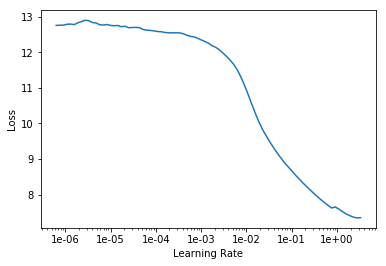

In [75]:
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(5, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.038732,0.035479,0.205602
2,0.045313,0.048367,0.189920
3,0.033022,0.025380,0.155994
4,0.022681,0.019510,0.134081
5,0.014578,0.013382,0.112550


In [77]:
learn.save('1')

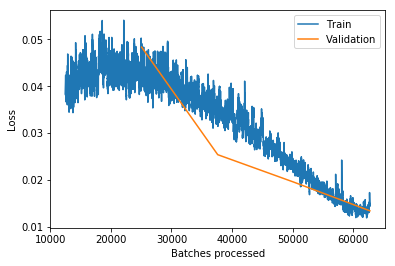

In [78]:
learn.recorder.plot_losses(last=-1)

In [79]:
learn.load('1');

In [80]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.014522,0.013249,0.115302
2,0.013317,0.015585,0.114949
3,0.012138,0.015493,0.110131
4,0.011693,0.016867,0.115624
5,0.011305,0.013228,0.109602


In [81]:
learn.save('2')

In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.012831,0.012518,0.106848
2,0.011145,0.013722,0.109208
3,0.011676,0.015752,0.115598
4,0.009419,0.012901,0.107179
5,0.009156,0.011122,0.103746


(10th place in the competition was 0.108)

## fin